In [17]:
import numpy as np
import pandas as pd   
import scipy
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [18]:
cg = 1.78
eps = 1e-2
laplace_scale = 1.0 / (2**.5)

In [19]:
np.random.seed(42)

## Helper Functions

In [22]:
def random_generator(n,a,gamma=(2*cg)**.5):
    """Draws random numbers from normal, laplace and cauchy distributions."""
    distributions = {}
    distributions['normal'] = a + np.random.randn(n)
    distributions['laplace'] = a + np.random.laplace(size = n,scale = laplace_scale)
    distributions['cauchy'] = a + scipy.stats.cauchy.rvs(size=n,loc = 0, scale = gamma)
    return distributions

def f(data,gamma,a):
    """Optimization function for the cauchy distribution (given gamma)."""
    return np.sum((a-data)/(1 + ((data-a)/gamma)**2))

def df_da(data,gamma,a):
    """derivative of f with respect to a."""
    return np.sum((1 - ((data-a)/gamma)**2)/((1 + ((data-a)/gamma)**2)**2))

def nr(data,guess,gamma,iterations=1000):
    """Newton-Raphson method for estimating the scale parameter of a Cauchy distribution."""
    for iteration in range(iterations):
        y = f(data,gamma, guess)
        dy_dA = df_da(data, gamma, guess)
        guess -= y/dy_dA
        if abs(y) < eps:
            break
    return guess

def grad_desc(data,guess,gamma,iterations=1000):
    """gradient descent method for estimating the location parameter of a cauchy distribution."""
    # print(guess)
    lr = 1e-3
    pguess = 1e5
    for _ in range(iterations):
        y = f(data,gamma, guess)
        # dy_da = df_da(data, gamma, guess)
        pguess = guess
        guess -= lr*y
        if abs(pguess-guess) < eps:
            break
        # print(guess)
    # print("over")
    return guess

def mle_estimates(distributions, gamma, guess):
    """Calculates the mle estimates for normal, laplace and cauchy distributions."""
    estimates = {}
    for key in distributions.keys():
        if key == 'normal':
            estimates[key] = np.mean(distributions[key])
        elif key == 'laplace':
            estimates[key] = np.median(distributions[key])
        elif key == 'cauchy':
            estimates[key] = nr(distributions[key], guess, gamma=gamma,iterations=10000)
    return estimates

def give_dataframe(stats, sample_sizes, num_realisations):
    data = {}
    for ni in sample_sizes:
        data[f"{ni}"]={}
        for nri in num_realisations:
            data[f"{ni}"][f"normal_{nri}"]={}
            data[f"{ni}"][f"laplace_{nri}"]={}
            data[f"{ni}"][f"cauchy_{nri}"]={}
    for nr in num_realisations:
        num_realisations = nr
        for ni in sample_sizes:
            data[f"{ni}"][f"normal_{nr}"] = rf"{stats[ni]["normal"]["mean"]:.3f} ± {np.sqrt(stats[ni]["normal"]["var"]):.3f}"
            data[f"{ni}"][f"laplace_{nr}"] = rf"{stats[ni]["laplace"]["mean"]:.3f} ± {np.sqrt(stats[ni]["laplace"]["var"]):.3f}"
            data[f"{ni}"][f"cauchy_{nr}"] = rf"{stats[ni]["normal"]["mean"]:.3f} ± {np.sqrt(stats[ni]["cauchy"]["var"]):.3f}"
    df = pd.DataFrame(data).T
    ordered_cols = [f"normal_{nr}" for nr in num_realisations]
    ordered_cols.extend([f"laplace_{nr}" for nr in num_realisations])
    ordered_cols.extend([f"cauchy_{nr}" for nr in num_realisations])
    df = df.loc[:,ordered_cols]
    print(df.head(100))

## Experiments

In [23]:
# from tqdm import tqdm

def realisations(n, a, num_realisations):
    """Generates random numbers and calculates MLE estimates for multiple realisations."""
    estimates = {"normal": [], "laplace": [], "cauchy": []}
    
    for _ in tqdm(
        range(num_realisations),
        desc=f"n={n} | Realisations",
        leave=False,
        dynamic_ncols=True,
    ):
        distributions = random_generator(n, a)
        if n%2 != 0:
            estimate = mle_estimates(distributions, gamma=(2 * cg) ** 0.5, guess=np.median(distributions["cauchy"]))
        else:
            estimate1 = mle_estimates(distributions, gamma=(2 * cg) ** 0.5, guess=distributions["cauchy"][n/2])
            estimate2 = mle_estimates(distributions, gamma=(2 * cg) ** 0.5, guess=distributions["cauchy"][n/2]-1)

            if (f(distributions["cauchy"],(2 * cg) ** 0.5,estimate1["cauchy"])
               >f(distributions["cauchy"],(2 * cg) ** 0.5,estimate2["cauchy"])):
                estimate  = estimate1
            else:
                estimate = estimate2

        for key in estimate:
            estimates[key].append(estimate[key])
    
    return estimates

def get_statistics(estimates):
    """Calculates mean and standard deviation of MLE estimates."""
    statistics = {}
    for key in estimates:
        statistics[key] = {
            'mean': np.mean(estimates[key]),
            'var': np.var(estimates[key])
        }
    return statistics

def iter_over_sample_size(ns, a, num_realisations, guess):
    """Iterates over different sample sizes and calculates MLE estimates."""
    estimates = {}
    stats = {}

    outer = tqdm(ns, desc="Sample Sizes", dynamic_ncols=True)
    for n in outer:
        outer.set_description(f"Sample size: n={n}")
        estimates[n] = realisations(n, a, num_realisations, guess=guess)
        stats[n] = get_statistics(estimates[n])
        outer.write(f"Done: n={n}, num_real={num_realisations}")
    
    return estimates, stats


## Plotting functions

In [12]:
def plot_cdf(data, stat ,label='CDF', color='blue', axis=None):
    """Plots the CDF of the data."""
    if axis is None:
        _, axis = plt.subplots(figsize=(5, 5), layout="constrained")
    sorted_data = np.sort(data)
    cdf = np.linspace(0, 1, len(sorted_data))
    axis.step(sorted_data, cdf, where='post', label=label, color=color)
    axis.set_xlabel(r'Value of $\hat{a}$')
    axis.set_ylabel('Cumulative Probability')
    axis.set_title(f"CDF of {label} with mean: {stat['mean']:.3E} var: {stat['var']:.3E}")
    axis.set_xlim(max(-2,np.min(data)), min(4,np.max(data)))
    # plt.legend()
    # plt.show()

def plot_cdf_pdf(ns,estimates,stats):
    for n in ns:
        _, axs = plt.subplots(3, 2, figsize=(10, 5), layout="constrained")
        for i,key in enumerate(estimates[n].keys()):
            axs[i,0].hist(estimates[n][key], density=True, bins=100, alpha=0.5, color='blue', label='PDF',range=(max(-2,np.min(estimates[n][key])), min(4,np.max(estimates[n][key]))))
            axs[i,0].set_title(f"PDF of {key} with sample size {n}")
            plot_cdf(estimates[n][key], stats[n][key], label=key, color='blue', axis=axs[i,1])
            axs[i,1].set_title(f"CDF of {key} with sample size {n}")
        plt.show()

def plot_mean_var(stats):
    _, axs = plt.subplots(1, 2, figsize=(10, 5), layout="constrained")
    mean, var = {"normal": [], "laplace": [], "cauchy": []},{"normal": [], "laplace": [], "cauchy": []}
    for n in stats.keys():
        for key in mean.keys():
            mean[key].append(stats[n][key]['mean'])
            var[key].append(stats[n][key]['var'])
    for key in mean.keys():
        axs[0].semilogy(stats.keys(), mean[key], label=key)
        axs[1].semilogy(stats.keys(), var[key], label=key)
    axs[0].set_xlabel(r'Sample Size')
    axs[0].set_ylabel(r'Mean of $\hat{a}$')
    axs[0].set_title(r'Mean of $\hat{a}$')
    # axs[0].set_xscale(r'log')
    axs[1].set_xlabel(r'Sample Size')
    axs[1].set_ylabel(r'Variance of $\hat{a}$')
    axs[1].set_title(r'Variance of $\hat{a}$')
    # axs[1].set_xscale(r'log')
    axs[0].legend()
    axs[1].legend()
    plt.show()

In [24]:
n = [1, 10, 100, 1000]#, 10000]#, 1000, 10000]
num_realisations = [10,100,1000]

In [ ]:
data = {}
for ni in n:
    data[f"{ni}"]={}
    for nri in num_realisations:
        data[f"{ni}"][f"normal_{nri}"]={}
        data[f"{ni}"][f"laplace_{nri}"]={}
        data[f"{ni}"][f"cauchy_{nri}"]={}
for nr in num_realisations:
    a = 1.0
    num_realisations = nr
    estimates_1, stats_1 = iter_over_sample_size(n,a,num_realisations,guess=1.0)
    for ni in n:
        data[f"{ni}"][f"normal_{nr}"] = rf"{stats_1[ni]["normal"]["mean"]:.3f} ± {np.sqrt(stats_1[ni]["normal"]["var"]):.3f}"
        data[f"{ni}"][f"laplace_{nr}"] = rf"{stats_1[ni]["laplace"]["mean"]:.3f} ± {np.sqrt(stats_1[ni]["laplace"]["var"]):.3f}"
        data[f"{ni}"][f"cauchy_{nr}"] = rf"{stats_1[ni]["normal"]["mean"]:.3f} ± {np.sqrt(stats_1[ni]["cauchy"]["var"]):.3f}"
df = pd.DataFrame(data).T
ordered_cols = [f"normal_{nr}" for nr in num_realisations]
ordered_cols.extend([f"laplace_{nr}" for nr in num_realisations])
ordered_cols.extend([f"cauchy_{nr}" for nr in num_realisations])
df = df.loc[:,ordered_cols]
df.head(100)


In [127]:
a = 10.0
estimates_10, stats_10 = iter_over_sample_size(n,a,num_realisations,guess=10.0)

n=1: 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


In [ ]:
a = 10.0
estimates_10, stats_10 = iter_over_sample_size(n,a,num_realisations)

In [128]:
stats_10

{1: {'normal': {'mean': np.float64(9.986157152603061),
   'var': np.float64(1.0067380872826732)},
  'laplace': {'mean': np.float64(9.98923502423808),
   'var': np.float64(1.0032271822724483)},
  'cauchy': {'mean': np.float64(13.162016213807782),
   'var': np.float64(93249.38274145656)}}}

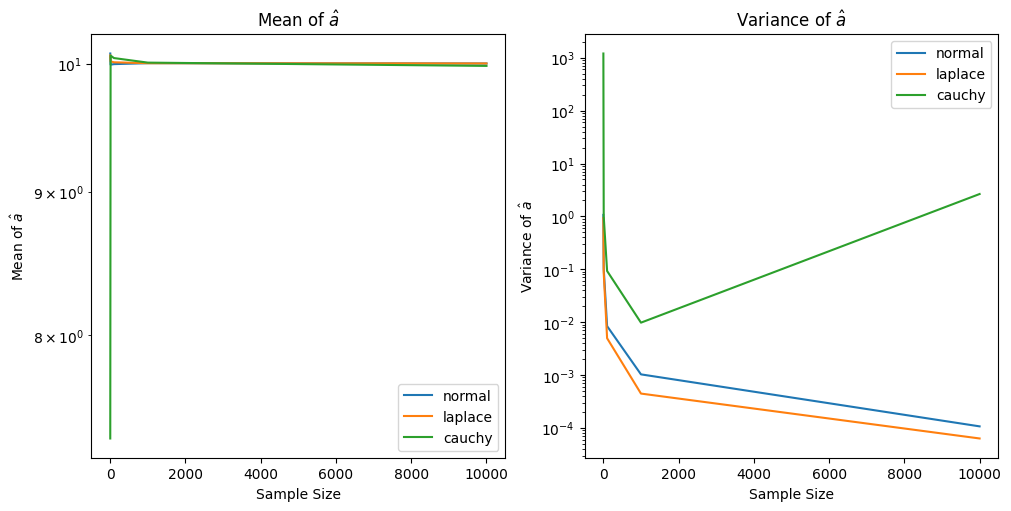

In [119]:
plot_mean_var(stats_10)

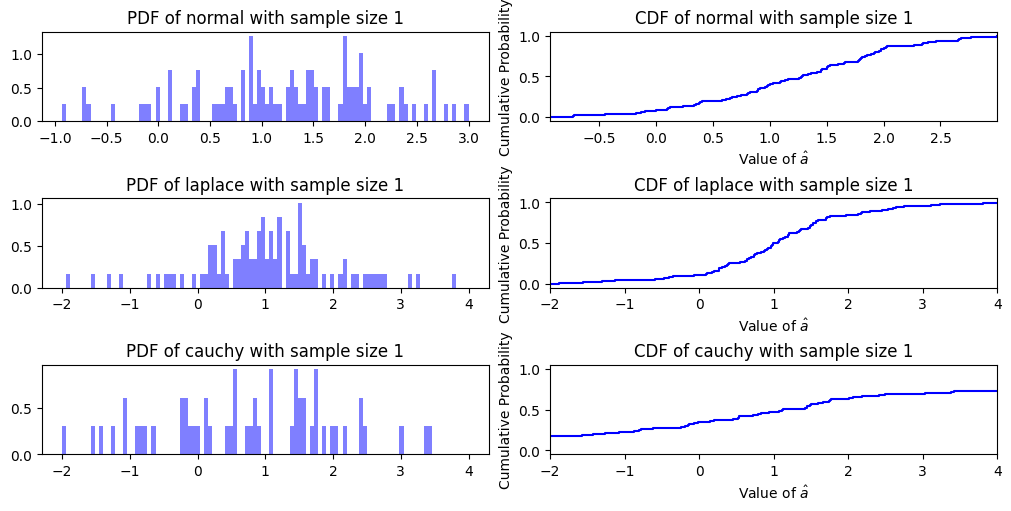

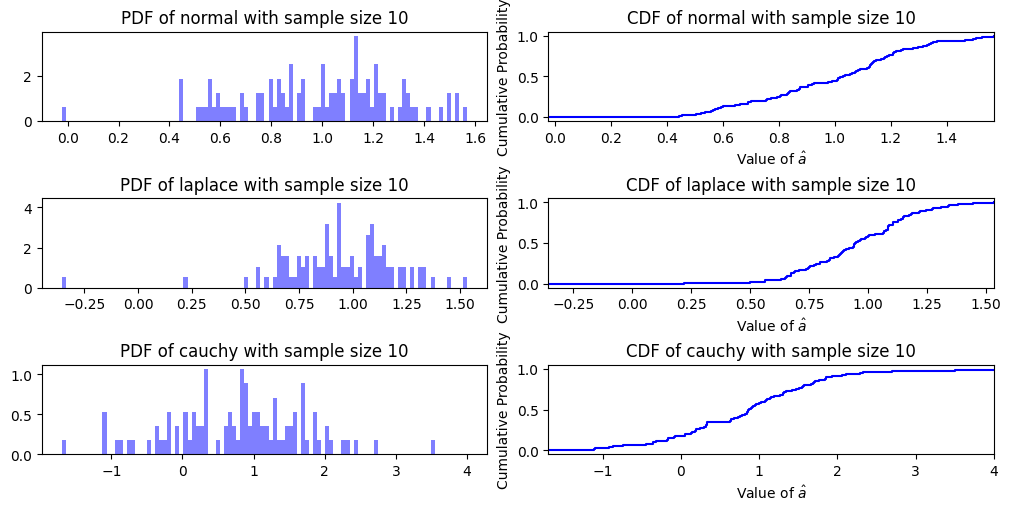

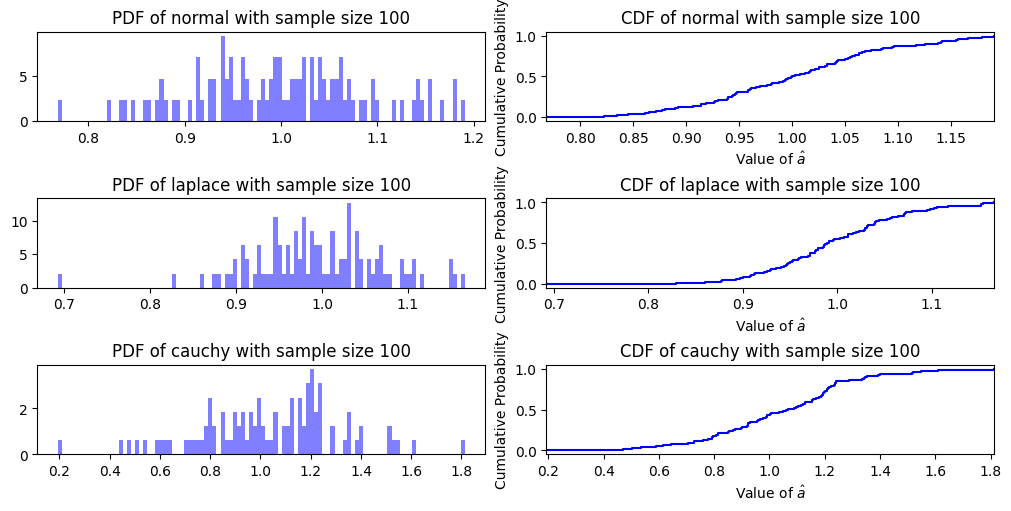

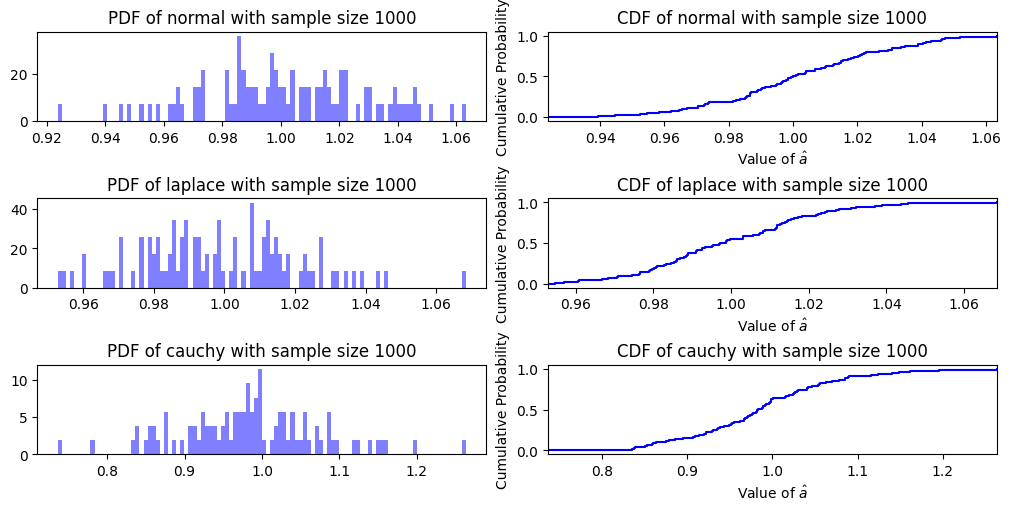

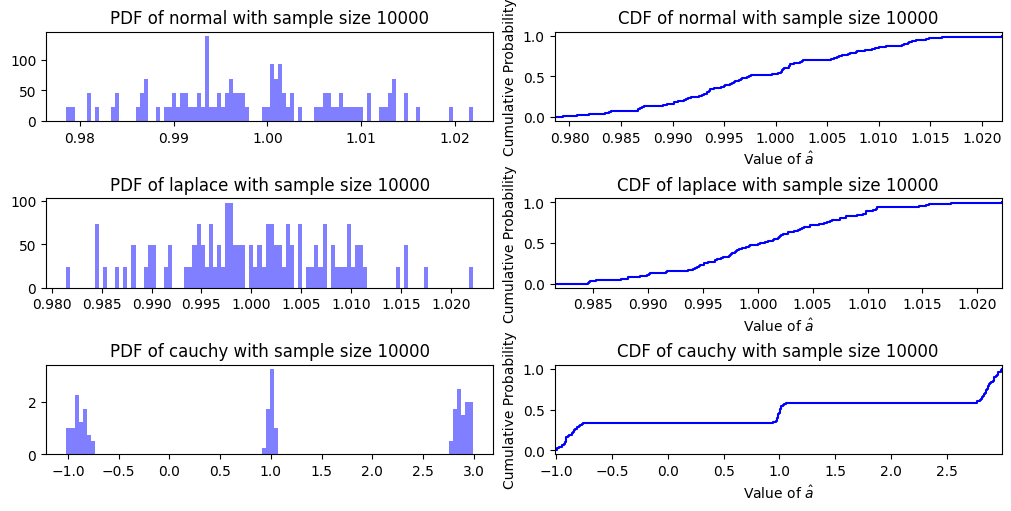

In [120]:
plot_cdf_pdf(n, estimates_1, stats_1)